In [1]:
# libraries for querying astro images and processing them
from astroquery.alma import Alma
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.modeling import models, fitting
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.table import *
import os
import skimage
from skimage.filters import *
import numpy as np
from skimage import io, exposure, morphology, filters, feature
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from math import sqrt
import scipy.optimize as opt
import statmorph
import photutils
import scipy.ndimage as ndi
import pandas as pd
from scipy import ndimage

# plotting libraries
from matplotlib import pylab
import pylab as py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import corner

# libraries for machine learning
from sklearn import decomposition
from sklearn import preprocessing
import scipy.stats as sstats

# random libraries
import time
import math
import warnings
import pickle

import multiprocessing as mp

plt.style.use(astropy_mpl_style)
sns.reset_orig()

In [2]:
RANDOM_STATE = 69

In [3]:
with open('full_data.pickle', 'rb') as f:
    full_data = pickle.load(f)

In [4]:
i = 0

directory = 'processed_images'

for name, image in full_data.items():
        img = image
        scale_factor = 1/(img.max()-img.min())
        img_scaled = (img-img.min())*scale_factor
        img_scaled = img_scaled*255
        cv2.imwrite(f'processed_images/{name}.jpg', img_scaled)
        print(i, end='\r')
        i += 1

# Normalisation + Centered Data PCA

In [5]:
## code for flattening and conducting PCA on images


# create data matrix

data_list = []
error_data_list = []

# sersic_fits[galaxy] = [original_img_data, image_model, theta, rhalfellip, rmaj, rhalf_circ, r20, r50, r80, 
                      # rmax_circ, rmax_ellip, rpetro_circ, rpetro_ellip, ellip, rmin, residual, 
                      # processed_image, processed_residual]

i = 0
        
for galaxy, item in full_data.items():
    try:
        
        #         preprocess and scale each image's pixel values
        img = item
        scale_factor = 1/(img.max()-img.min())
        img_scaled = (img-img.min())*scale_factor
        img_scaled -= img_scaled.mean() # center data
        

#         transformer = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit(img)
#         img_scaled = transformer.transform(img)
# #         img_scaled = np.log(img_scaled)

#         img_min = img.min()
    
#         if img_min < 0:
#             img_scaled = img - img_min
#         else:
#             img_scaled = img
                                                                                              
        data_row = img_scaled.flatten()
        data_list.append(data_row)
        
    except:
        error_data_list.append(galaxy)
        
    print(i, end='\r')
    i += 1
    
data_matrix = np.vstack(data_list)


In [6]:
# conduct pca

# conduct PCA

NO_COMPONENTS = 64

pca = decomposition.PCA(n_components=NO_COMPONENTS, random_state=RANDOM_STATE)
pca.fit(data_matrix)

pca_matrix = pca.components_[:NO_COMPONENTS]



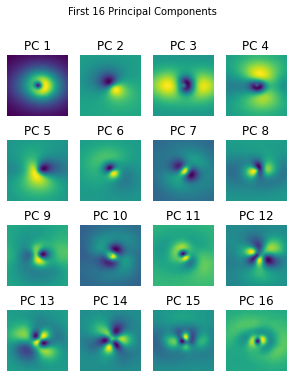

In [7]:
###### plot PCA components
fig, axes = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
ax = axes.ravel()
fig.suptitle('First 16 Principal Components', fontsize=10,)

i = 0

for row, var, val in zip(pca_matrix, pca.explained_variance_ratio_, pca.singular_values_):
    
    component = row.reshape([100, 100])
    ax[i].set_title(f'PC {i+1}')
    ax[i].imshow(component, )
    ax[i].axis('off')

    print(i, end='\r')
    i += 1
    if i == 16:
        break



In [8]:
# reconstruct original images from components

y = (pca.explained_variance_ratio_*100).tolist()
x = list(range(0, len(y)))
cumulative = np.cumsum(y)

print(sum(y[:12]))
plt.title('Principal Components and Explained Variance',fontsize=20)
plt.xlabel('Principal Component no. (eigenvectors)')
plt.ylabel('Explained Variance Ratio (eigenvalues)')
plt.xticks(ticks=list(range(0, 21, 2)))
plt.xlim(0, 20)
plt.scatter(x, y, label='Eigenvalues')
plt.plot(x, cumulative, label='Cumulative Eigenval', color='red', linewidth=0.5)

# markers
plt.hlines(y=85, xmin=0, xmax=20, label='85% Total', linestyles='--', color='purple')
plt.hlines(y=90, xmin=0, xmax=20, label='90% Total', linestyles='--', color='green')


plt.legend(loc='best')

90.27969500422478


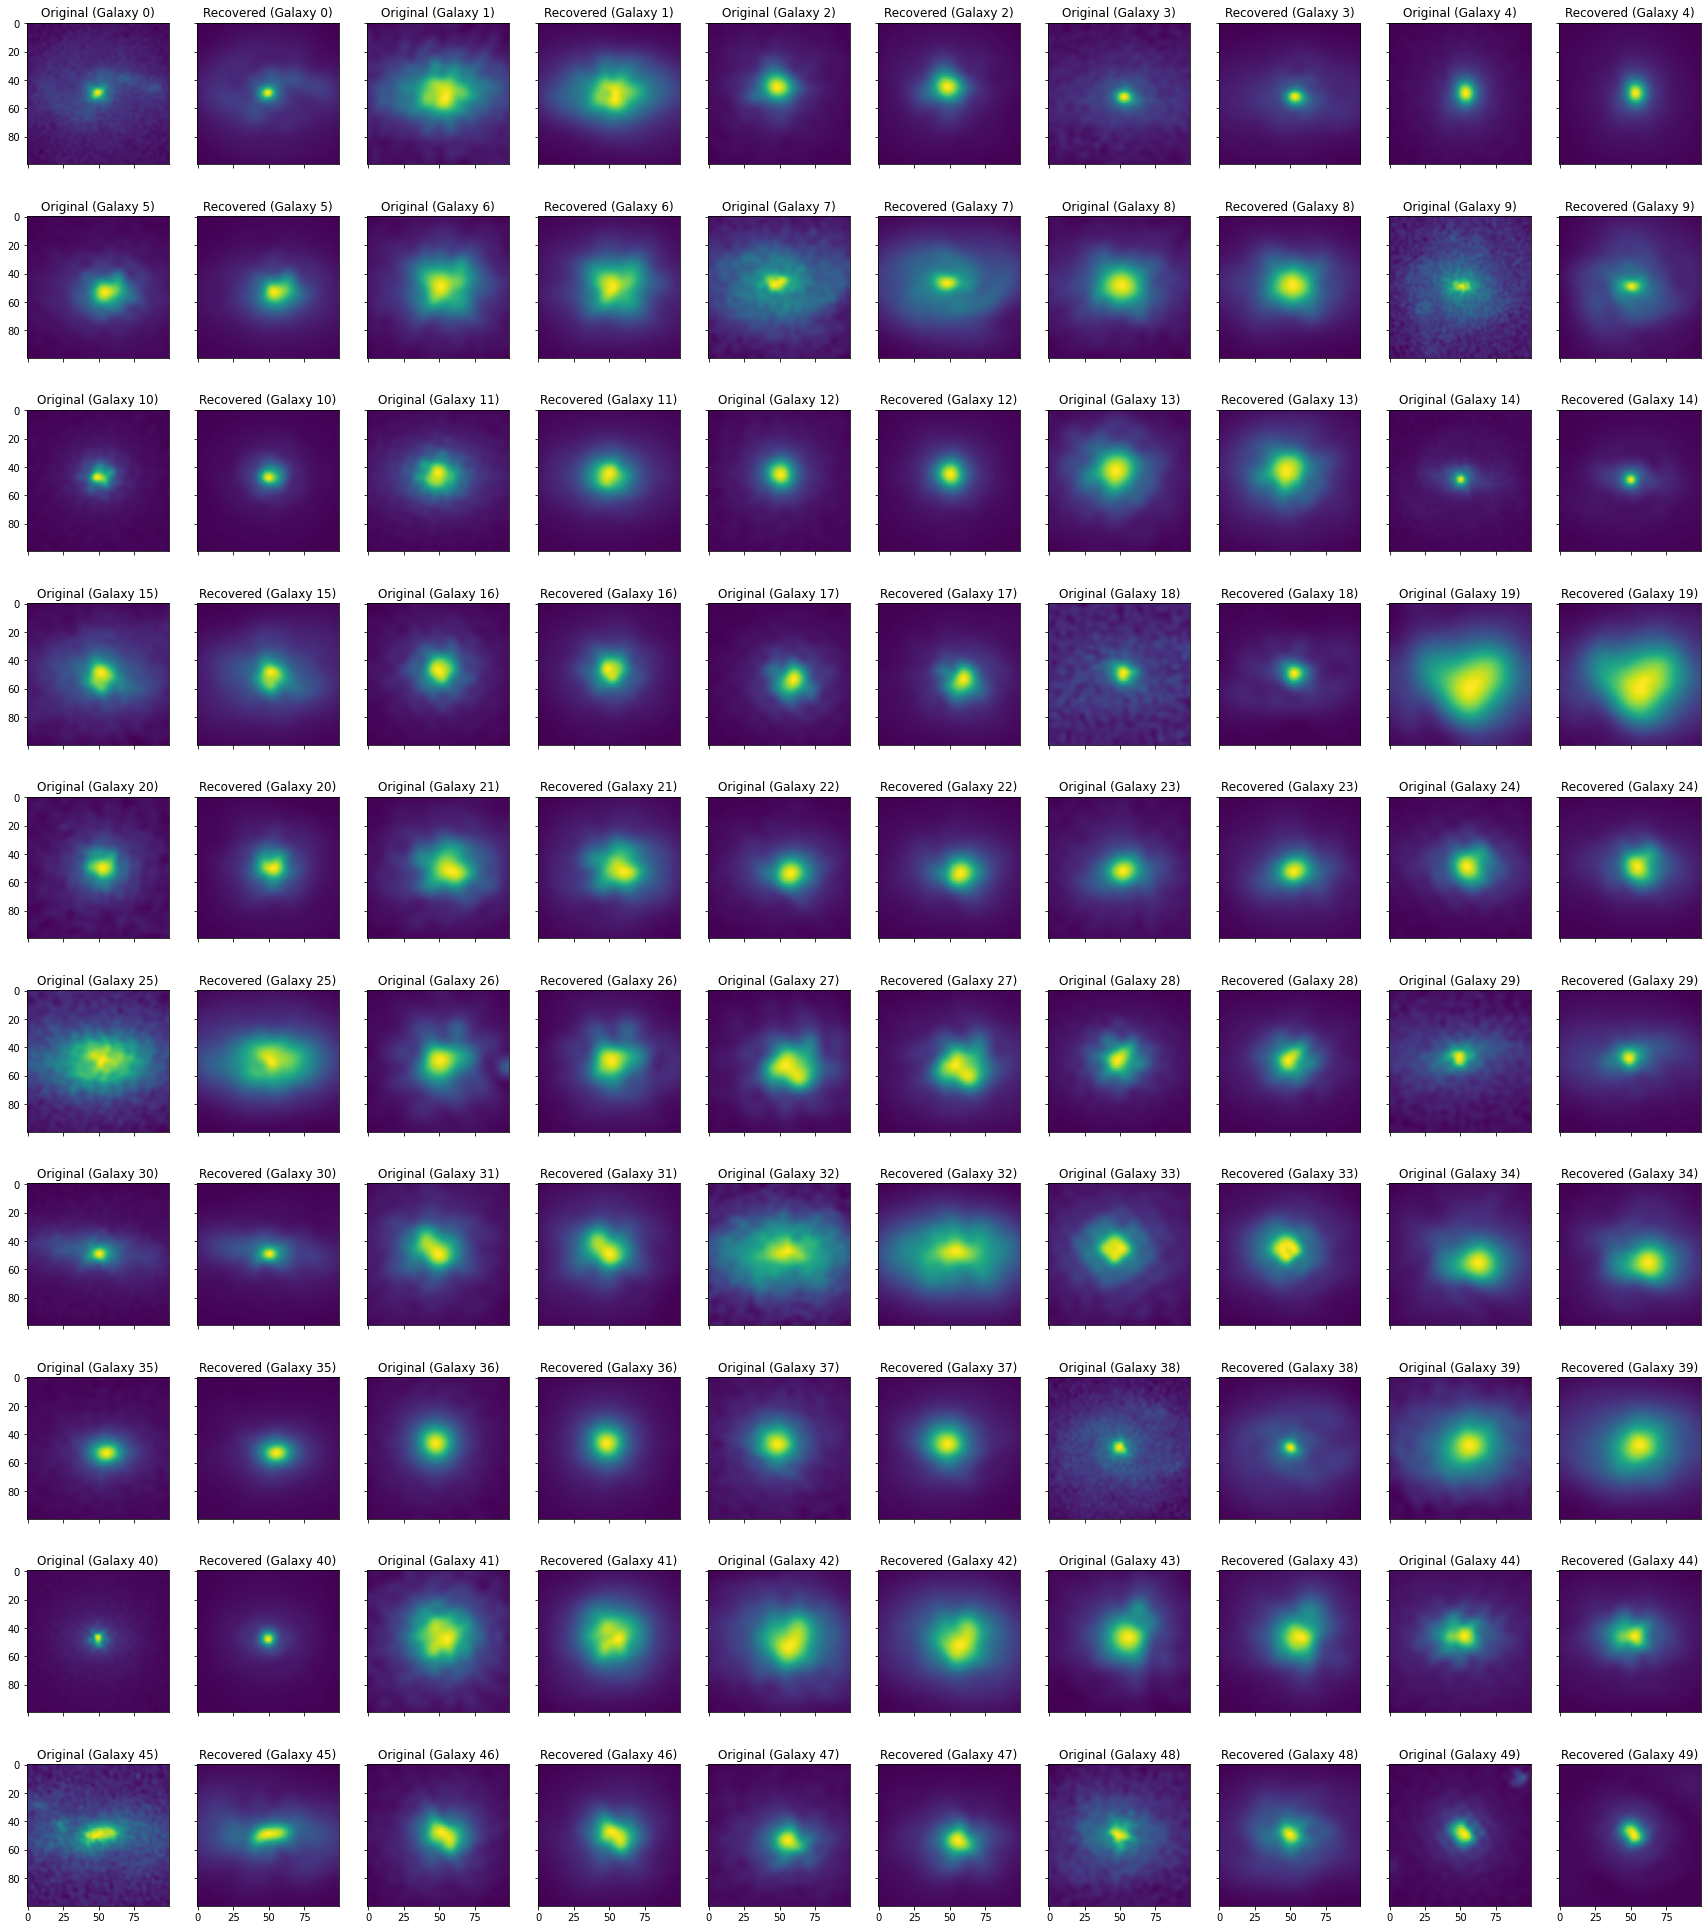

In [9]:
fig, axes = plt.subplots(10, 10, figsize=(30, 35), sharex=True, sharey=True)
ax = axes.ravel()


trans = pca.transform(data_matrix)

inv = pca.inverse_transform(trans)

i = 0
j = 0

while j < 50:
    ax[i].imshow(data_matrix[j].reshape((100,100)))
    ax[i].set_title(f'Original (Galaxy {j})')
    ax[i+1].imshow(inv[j].reshape([100, 100]))
    ax[i+1].set_title(f'Recovered (Galaxy {j})')
    j += 1
    i += 2



0.007858105024857906
0.004167858539850481
0.002232554507769766
0.0015136839363488184
0.0012038927409449426
0.0010205382056128125


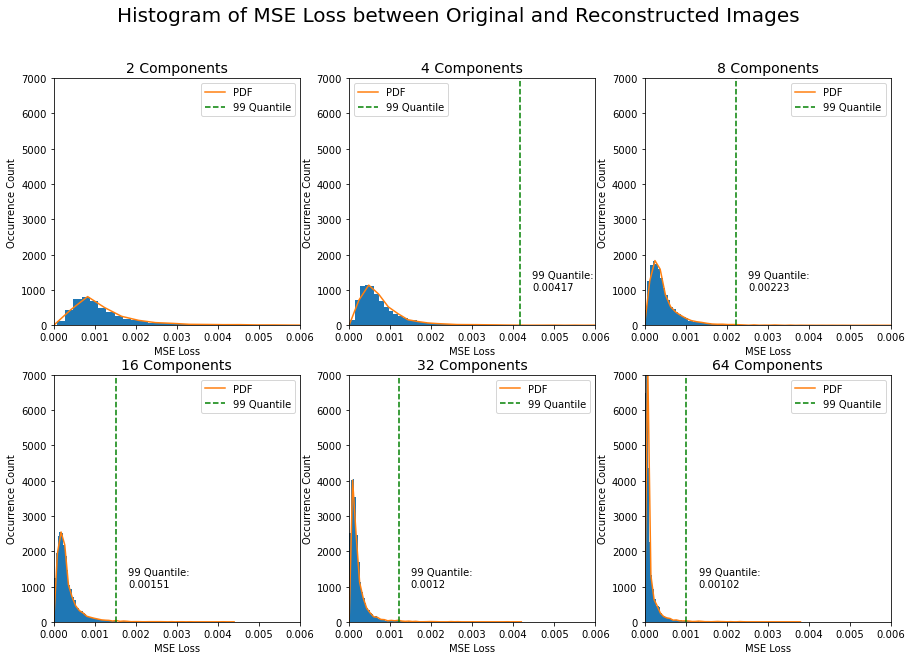

In [27]:
# calculate fractional difference of pixel values for each pair of images
fig, axes = plt.subplots(2, 3, figsize=(15, 10),)
ax = axes.ravel()

NO_PC = [2, 4, 8, 16, 32, 64]

img_differences_dict = {}

for i in range(len(NO_PC)):
    k = NO_PC[i]
    img_differences = []
    pca = decomposition.PCA(n_components=k, random_state=RANDOM_STATE)
    pca.fit(data_matrix)

    trans = pca.transform(data_matrix)
    inv = pca.inverse_transform(trans)
    
    for j in range(inv.shape[0]):
        orig = data_matrix[j]
        recon = inv[j]
    
        img_diff = (1/inv.shape[0])*(np.square(orig-recon).sum()) # Mean squared error loss
        img_differences.append(img_diff)
    
    
    
    hist = np.histogram(img_differences, bins=100)
    hist_dist = sstats.rv_histogram(hist)
    X = np.linspace(0, max(img_differences), 50)
    
    img_differences_dict[k] = [img_differences, hist_dist]
    ppf = hist_dist.ppf(q=0.99)
    print(ppf)
    ax[i].hist(x = img_differences, bins=100, density=True)
    ax[i].plot(X, hist_dist.pdf(X), label='PDF')
    ax[i].axvline(x=ppf, ymin=0, ymax=7000, linestyle='--', color='green', label='99 Quantile')
    ax[i].legend()
    ax[i].set_ylim([0, 7000])
    ax[i].set_xlim([0, 0.006])
    ax[i].set_xticks([0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006])
    ax[i].text(x=ppf+0.0003, y=1000, s=f'99 Quantile:\n{round(ppf, 5)}')
    ax[i].set_title(f'{k} Components', fontsize=14)
    ax[i].set_ylabel('Occurrence Count')
    ax[i].set_xlabel('MSE Loss')
    fig.suptitle('Histogram of MSE Loss between Original and Reconstructed Images', fontsize=20)

0.0061363142156478185


Text(0.5, 0, 'MSE Loss')

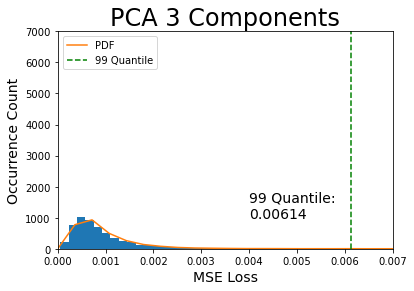

In [41]:
k = 3
img_differences = []
pca = decomposition.PCA(n_components=k, random_state=RANDOM_STATE)
pca.fit(data_matrix)

trans = pca.transform(data_matrix)
inv = pca.inverse_transform(trans)

for j in range(inv.shape[0]):
    orig = data_matrix[j]
    recon = inv[j]

    img_diff = (1/inv.shape[0])*(np.square(orig-recon).sum()) # Mean squared error loss
    img_differences.append(img_diff)

hist = np.histogram(img_differences, bins=100)
hist_dist = sstats.rv_histogram(hist)
X = np.linspace(0, max(img_differences), 50)

img_differences_dict[k] = [img_differences, hist_dist]
ppf = hist_dist.ppf(q=0.99)
print(ppf)
plt.hist(x = img_differences, bins=100, density=True)
plt.plot(X, hist_dist.pdf(X), label='PDF')
plt.axvline(x=ppf, ymin=0, ymax=7000, linestyle='--', color='green', label='99 Quantile')
plt.legend()
plt.xlim([0, 0.007])
plt.ylim([0, 7000])
plt.xticks([0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
plt.text(x=0.004, y=1000, s=f'99 Quantile:\n{round(ppf, 5)}', fontsize=14)
plt.title(f'PCA 3 Components', fontsize=24)
plt.ylabel('Occurrence Count', fontsize=14)
plt.xlabel('MSE Loss', fontsize=14)

We note that with increasing numbers of principal components used in the reconstruction of images, the Mean Squared Error between the original and reconstructed images

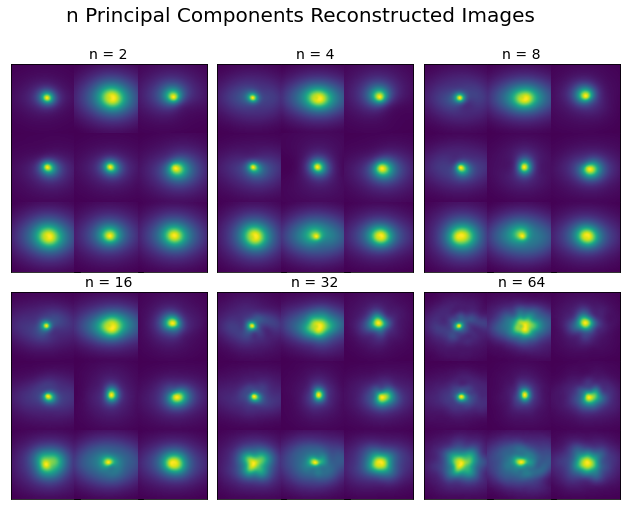

In [47]:
# calculate fractional difference of pixel values for each pair of images
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
outer_grid = fig.add_gridspec(2, 3, wspace=-0.57, hspace=0.1)

NO_PC = [2, 4, 8, 16, 32, 64]

i = 0

for a in range(2):
    for b in range(3):
        
        k = NO_PC[i]
        pca = decomposition.PCA(n_components=k)
        pca.fit(data_matrix)
        trans = pca.transform(data_matrix)
        inv = pca.inverse_transform(trans)
        
        j = 0
        
        # gridspec inside gridspec
        inner_grid = outer_grid[a, b].subgridspec(3, 3, wspace=-0.82, hspace=0)
        axs = inner_grid.subplots()  # Create all subplots for the inner grid.
        for (c, d), ax in np.ndenumerate(axs):
            ax.imshow(inv[j].reshape((100, 100)))
            ax.set(xticks=[], yticks=[])
            j += 1
        
        i += 1

            
            
# show only the outside spines
ii = 0

for i, ax in enumerate(fig.get_axes(), 1):
    ss = ax.get_subplotspec()
    if i in list(range(2, 55, 9)):
        ax.set_title(f'n = {NO_PC[ii]}', fontsize=14)
        ii += 1
        
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())

fig.suptitle('n Principal Components Reconstructed Images', fontsize=20)

plt.show()




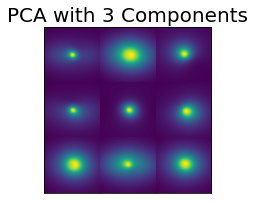

In [39]:
fig = plt.figure(figsize=(3, 5), constrained_layout=False)
outer_grid = fig.add_gridspec(1, 1, wspace=-0.57, hspace=0.1)


k = 3
pca = decomposition.PCA(n_components=k)
pca.fit(data_matrix)
trans = pca.transform(data_matrix)
inv = pca.inverse_transform(trans)

j = 0

# gridspec inside gridspec
inner_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0, hspace=-0.66)
axs = inner_grid.subplots()  # Create all subplots for the inner grid.
for (c, d), ax in np.ndenumerate(axs):
    ax.imshow(inv[j].reshape((100, 100)))
    ax.set(xticks=[], yticks=[])
    j += 1
    
    
# show only the outside spines
ii = 0

for i, ax in enumerate(fig.get_axes(), 1):
    ss = ax.get_subplotspec()
    if i == 2:
        ax.set_title('PCA with 3 Components', fontsize=20)
        ii += 1
        
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())

plt.show()

In [39]:
# original 9 galaxies

fig = plt.figure(figsize=(3, 5), constrained_layout=False)
outer_grid = fig.add_gridspec(1, 1, wspace=0, hspace=0)

j = 0

# gridspec inside gridspec
inner_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0, hspace=-0.66)
axs = inner_grid.subplots()  # Create all subplots for the inner grid.
for (c, d), ax in np.ndenumerate(axs):
    ax.imshow(data_matrix[j].reshape((100, 100)))
    ax.set(xticks=[], yticks=[])
    j += 1


# show only the outside spines

for i, ax in enumerate(fig.get_axes(), 1):
    ss = ax.get_subplotspec()
    if i == 2:
        ax.set_title('Original', fontsize=20)
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())

plt.show()




In [8]:
rcsed = Table.read('rcsedzoogz2gswlcx.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)

In [6]:
k = 3
img_differences = []
pca = decomposition.PCA(n_components=k, random_state=RANDOM_STATE)
pca.fit(data_matrix)

trans = pca.transform(data_matrix)


In [10]:
with open('cls.pickle', 'rb') as f:
    cls = pickle.load(f)

In [11]:
sns_df = pd.DataFrame(data=trans)
sns_df['type'] = cls


In [12]:
with open('r50.pickle', 'rb') as f:
    r50_list = pickle.load(f)

In [13]:
sns_df['r50'] = r50_list

In [ ]:
print(sns_df)

In [45]:
# Latent space

# conduct pca

# conduct PCA

NO_COMPONENTS = 3

pca = decomposition.PCA(n_components=NO_COMPONENTS, random_state=RANDOM_STATE)
pca.fit(data_matrix)

pca_matrix = pca.components_[:NO_COMPONENTS]
trans = pca.transform(data_matrix)

In [35]:
spiral_gals = []
ellip_gals = []
uncertain_gals = []

for i in range(len(cls)):
    if cls[i] == 'spiral':
        spiral_gals.append(trans[i])
    if cls[i] == 'elliptical':
        ellip_gals.append(trans[i])
    if cls[i] == 'uncertain':
        uncertain_gals.append(trans[i])
        
    print(i+1, end='\r')

4799

# Preparing dataset for plotting

In [7]:
# initialise dataframe with galaxy information

rcsed = Table.read('rcsedzoogz2gswlcx.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)

i = 0

for j in range(3):
    data[f'PC {j+1}'] = None

for n, galaxy in enumerate(full_data.keys(), 0):

    try:
        index = data.loc[(data['radec'] == galaxy)].index

        for j in range(len(trans[n])):
            data.at[index[0], f'PC {j+1}'] = trans[n][j]

        print(i, end='\r')
        i += 1
    except:
        continue

    

In [8]:
final_dataset = data[data['PC 1'].isna() == False]

# Plot Latent Space with Morph Type

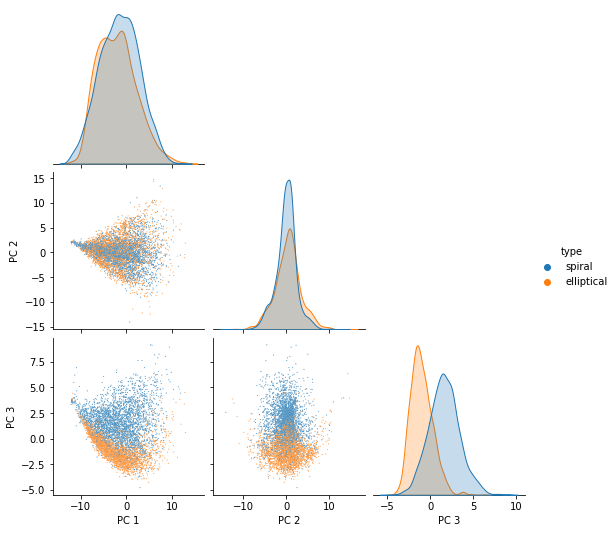

In [18]:
# seaborn pairplot


headers = []

for i, header in enumerate(sns_df.columns[:-2], 1):
    headers.append(f'PC {i}')

headers.append('type')
headers.append('r50')
sns_df.columns = headers

pp = sns.pairplot(data=sns_df[sns_df['type']!='uncertain'].iloc[:, :-1], hue='type', corner=True, plot_kws={"s": 1})
# pp = sns.pairplot(data=sns_df, hue='type', corner=True)


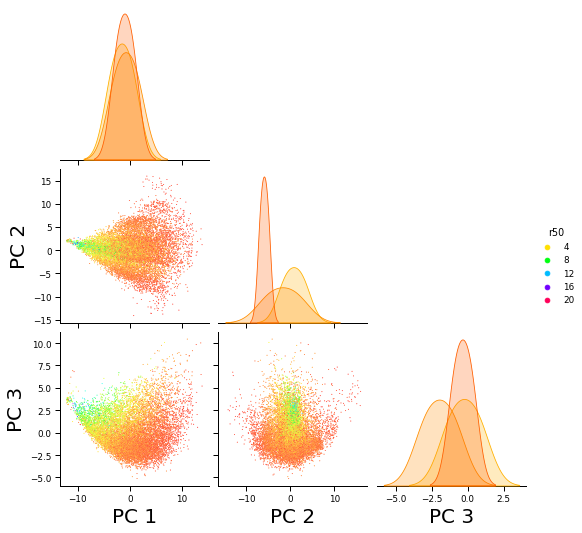

In [88]:
pp = sns.pairplot(data=sns_df, hue='r50', palette='hsv',corner=True, plot_kws={"s": 1})

Text(0.5, 1.104, '3D Latent Space Representation of Galaxies')

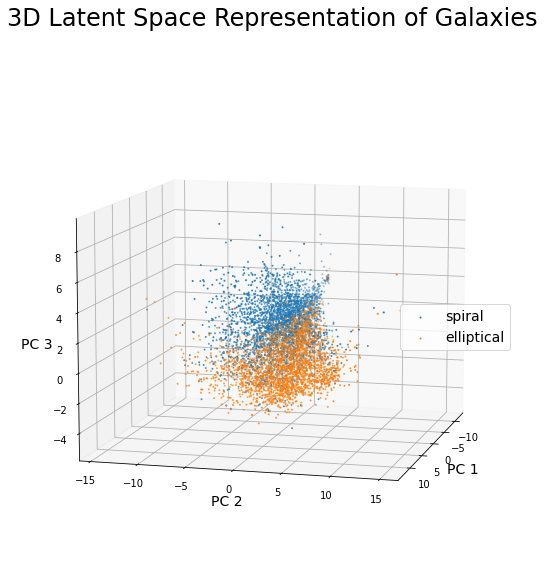

In [16]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(projection='3d')
for c in sns_df['type'].unique(): 
    if c == 'uncertain':
        continue
    x = sns_df[sns_df['type'] == c]['PC 1']
    y = sns_df[sns_df['type'] == c]['PC 2']
    z = sns_df[sns_df['type'] == c]['PC 3']
    ax.scatter(x, y, z, s=1, label=c)

    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=15)

plt.legend(fontsize=14, loc='center right')
plt.title('3D Latent Space Representation of Galaxies', fontsize=24, y=1.2)

# PC vs R50

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log Petrosian R50')

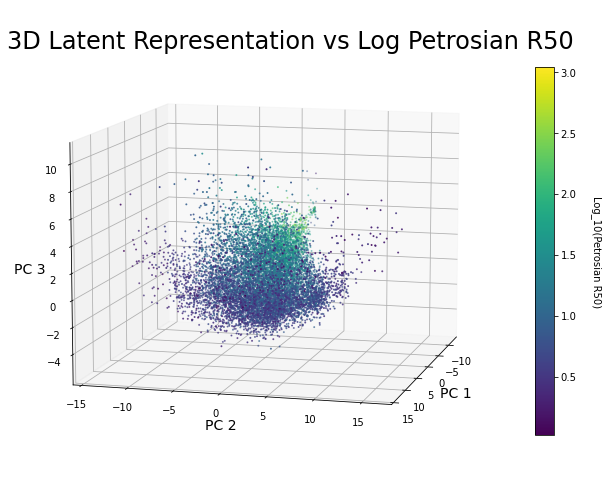

In [20]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['PC 1']
y = final_dataset['PC 2']
z = final_dataset['PC 3']

c = final_dataset['petror50_r']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Petrosian R50)', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log Petrosian R50', fontsize=24, x=0.55, y=0.98)

# PC vs Age

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Age (SSP) Myr')

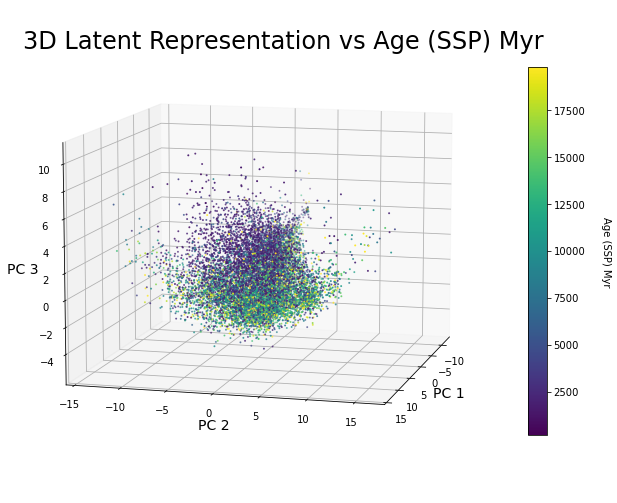

In [20]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['PC 1']
y = final_dataset['PC 2']
z = final_dataset['PC 3']

c = final_dataset['ssp_age']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Age (SSP) Myr', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Age (SSP) Myr', fontsize=24, x=0.55, y=0.98)

# PC vs Velocity Dispersion

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s')

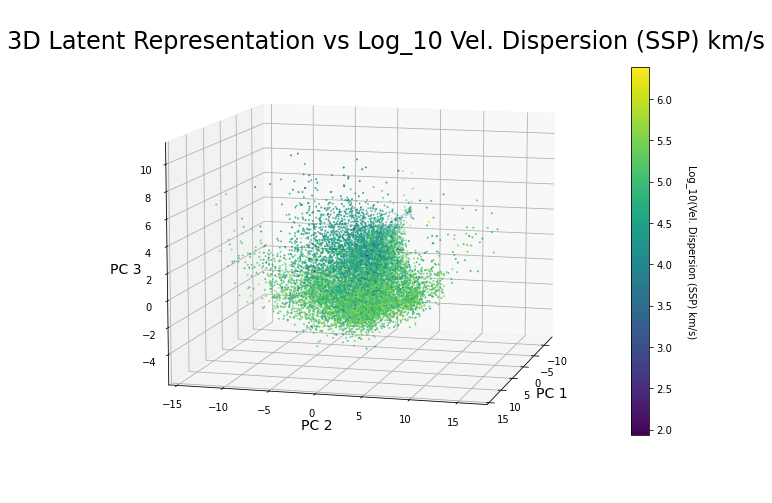

In [21]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['PC 1']
y = final_dataset['PC 2']
z = final_dataset['PC 3']

c = final_dataset['ssp_veldisp']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Vel. Dispersion (SSP) km/s)', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s', fontsize=24, x=0.55, y=0.98)

# PC vs LOGMSTAR

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log Stellar Mass')

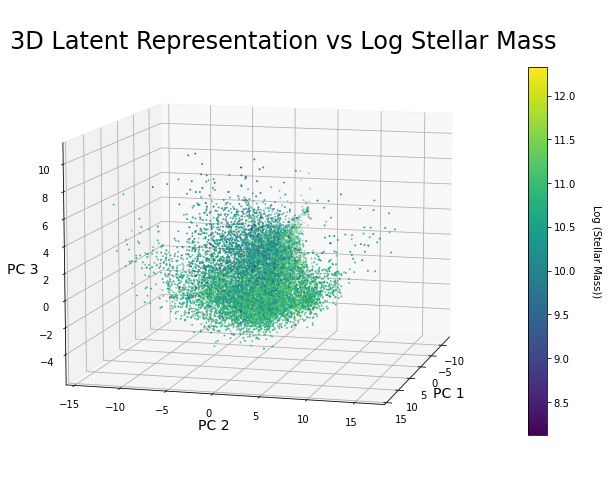

In [25]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGMSTAR'] != -99]

x = sub['PC 1']
y = sub['PC 2']
z = sub['PC 3']

c = sub['LOGMSTAR']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (Stellar Mass))', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log Stellar Mass', fontsize=24, x=0.55, y=0.98)

Text(0.5, 1, 'PC Pairs vs LOGMSTAR')

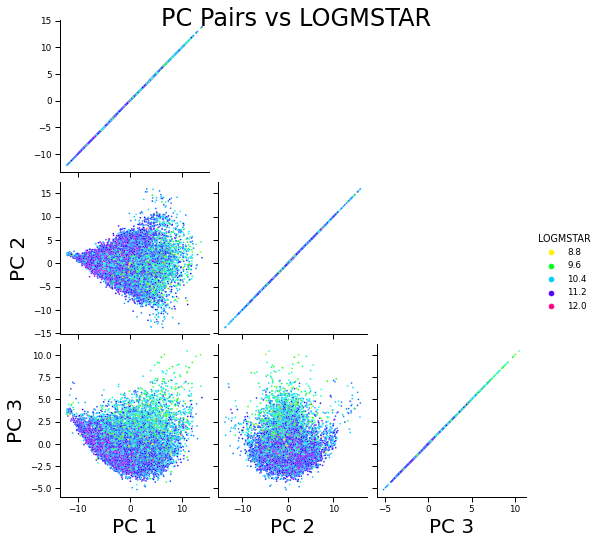

In [86]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub.loc[:, ['PC 1', 'PC 2', 'PC 3', 
                  'LOGMSTAR']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGMSTAR', palette='hsv', corner=True, plot_kws={"s": 3}, diag_kind=None)
pp.fig.suptitle('PC Pairs vs LOGMSTAR', fontsize=24, y=1)

# PC vs LOGSFRSED

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log SFR')

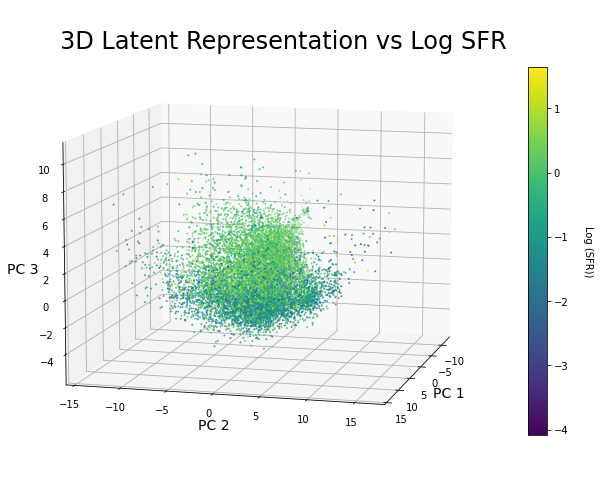

In [21]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGSFRSED'] != -99]

x = sub['PC 1']
y = sub['PC 2']
z = sub['PC 3']

c = sub['LOGSFRSED']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (SFR))', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log SFR', fontsize=24, x=0.55, y=0.98)

Text(0.5, 1, 'PC Pairs vs LOGSFR')

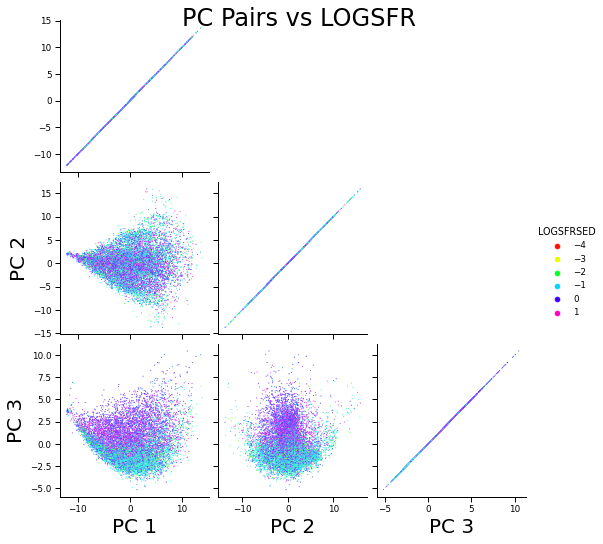

In [87]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub.loc[:, ['PC 1', 'PC 2', 'PC 3',
                  'LOGSFRSED']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGSFRSED', palette='hsv',corner=True, plot_kws={"s": 1}, diag_kind=None)
pp.fig.suptitle('PC Pairs vs LOGSFR', fontsize=24, y=1)

# PC vs LOGSSFR

In [32]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]

sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'Feat. 3', 'LOGMSTAR', 'LOGSFRSED']]
sub['LOGSSFR'] = np.log(np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR']))
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'Feat. 3', 'LOGSSFR']]

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = sub['PC 1']
y = sub['PC 2']
z = sub['PC 3']

c = sub['LOGSSFR']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_zlabel('PC 3', fontsize=14)
ax.view_init(elev=10, azim=80)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (SSFR)', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log SSFR', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log SSFR')

Text(0.5, 1.05, 'PC Pairs vs LOGSSFR')

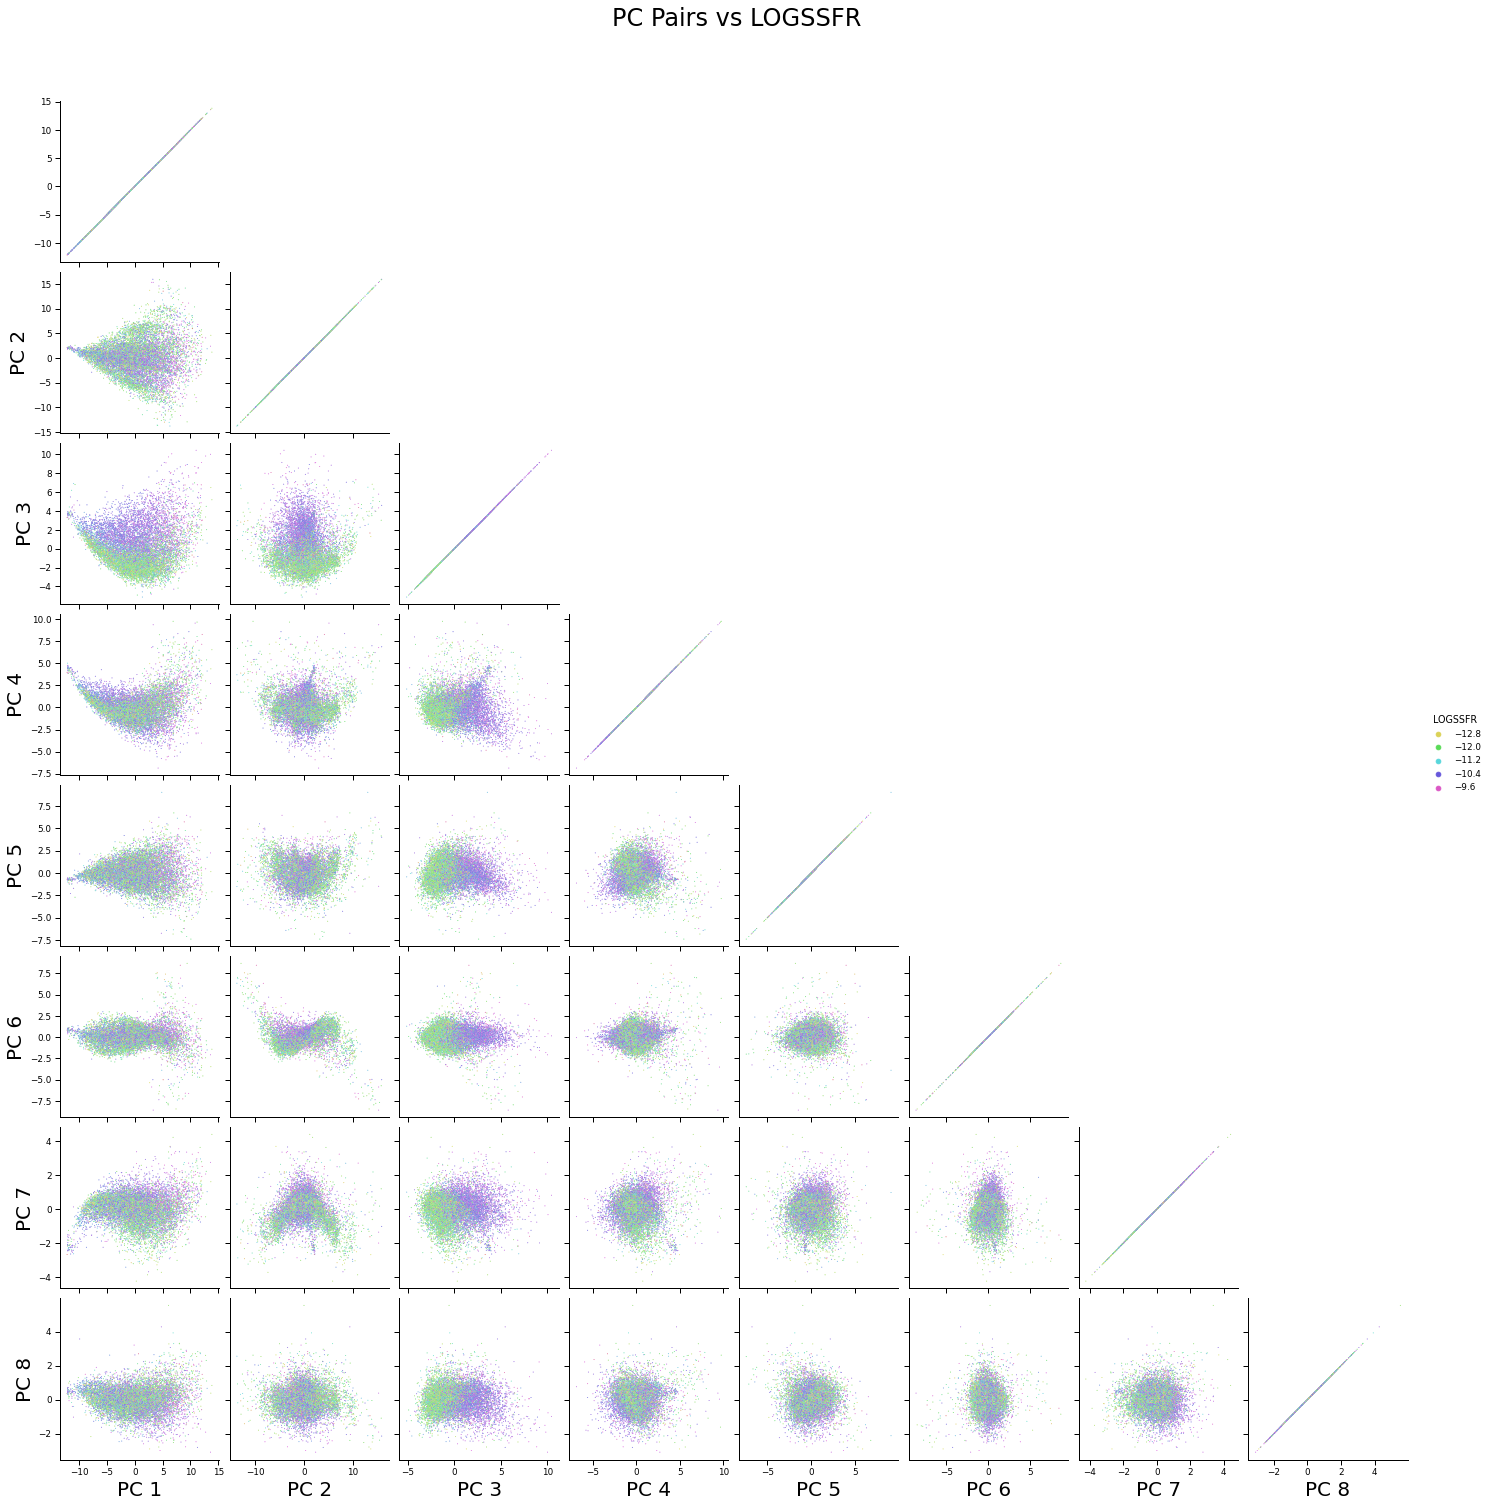

In [44]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]

sub = sub.loc[:, ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8',
                  'LOGMSTAR', 'LOGSFRSED']]
sub['LOGSSFR'] = np.log(np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR']))
sub = sub.loc[:, ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8',
                  'LOGSSFR']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGSSFR', palette='hls', corner=True, plot_kws={"s": 1}, diag_kind=None)
pp.fig.suptitle('PC Pairs vs LOGSSFR', fontsize=24, y=1.05)


Text(0.5, 1.05, 'PC Pairs vs LOGSSFR')

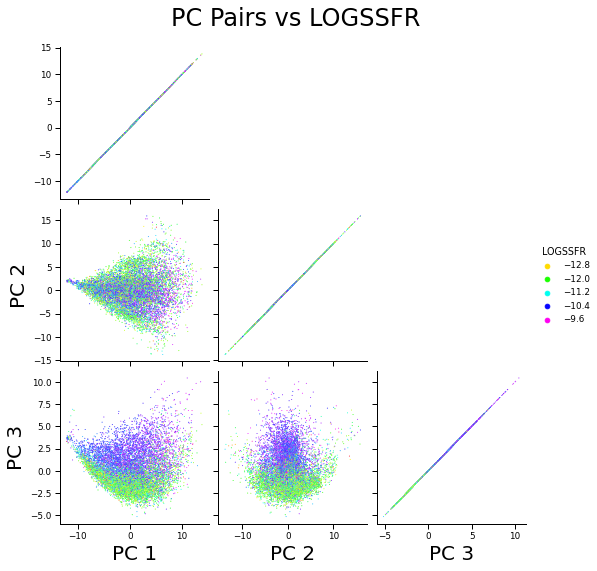

In [85]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]

sub = sub.loc[:, ['PC 1', 'PC 2', 'PC 3',
                  'LOGMSTAR', 'LOGSFRSED']]
sub['LOGSSFR'] = np.log(np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR']))
sub = sub.loc[:, ['PC 1', 'PC 2', 'PC 3',
                  'LOGSSFR']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGSSFR', palette='hsv', corner=True, plot_kws={"s": 1}, diag_kind=None)
pp.fig.suptitle('PC Pairs vs LOGSSFR', fontsize=24, y=1.05)


In [64]:
spiral_data = np.array(spiral_gals)
ellip_data = np.array(ellip_gals)
uncertain_data = np.array(uncertain_gals)

Text(0.5, 0.98, 'Latent Space Representation of Galaxies')

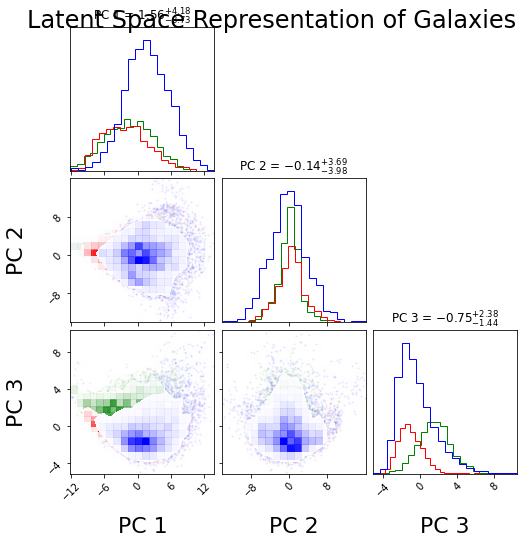

In [65]:
# corner plot

# make labels for each PC
labels = []
for x in range(1, NO_COMPONENTS+1):
    labels.append(f'PC {x}')
    
CORNER_PC = 3

figure = corner.corner(spiral_data[:, :CORNER_PC], color='green', show_titles=True, labels=labels, 
                       top_ticks=False, plot_contours=False, label_kwargs=dict(fontsize=22)) #plot spiral data

corner.corner(ellip_data[:, :CORNER_PC], color='red', show_titles=True, labels=labels, 
                       top_ticks=False, plot_contours=False, fig=figure) #plot ellip data


corner.corner(uncertain_data[:, :CORNER_PC], color='blue', show_titles=True, labels=labels, 
                       top_ticks=False, plot_contours=False, fig=figure) #plot uncertain data


figure.suptitle('Latent Space Representation of Galaxies', fontsize=24)

Text(0.6, 1.1, 'Latent Space Representation of Galaxies')

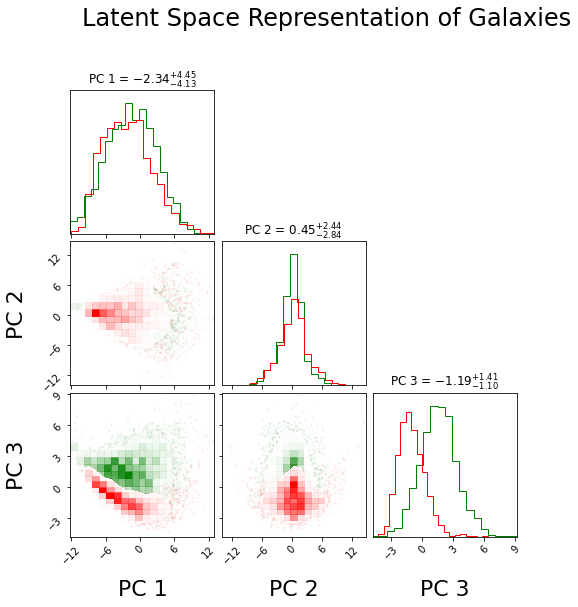

In [75]:
# corner plot

# make labels for each PC
labels = []
for x in range(1, NO_COMPONENTS+1):
    labels.append(f'PC {x}')
    
SPIRAL_FEATURES = [6, 10, 15]
CORNER_PC = 3

figure = corner.corner(spiral_data[:, :3*CORNER_PC], color='green', show_titles=True, labels=labels, 
                       top_ticks=False, plot_contours=False, label_kwargs=dict(fontsize=22)) #plot spiral data

corner.corner(ellip_data[:, :3*CORNER_PC], color='red', show_titles=True, labels=labels, 
                       top_ticks=False, plot_contours=False, fig=figure) #plot ellip data


# corner.corner(uncertain_data[:, SPIRAL_FEATURES], color='blue', show_titles=True, labels=labels, 
#                        top_ticks=False, plot_contours=False, fig=figure) #plot uncertain data


figure.suptitle('Latent Space Representation of Galaxies', fontsize=24, x=0.6, y=1.1)

In [46]:
# initialise dataframe with galaxy information

rcsed = Table.read('rcsedzoogz2gswlcx.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)


In [3]:
# find correlations between eigenvalues and galaxy properties

cob = pca.components_

i = 0

for j in range(pca.components_.shape[0]):
    data[f'eval_{j}'] = None

for galaxy, model in full_data.items():
    img = model
    scale_factor = 1/(img.max()-img.min())
    img_scaled = (img-img.min())*scale_factor
    img_scaled  = img_scaled - img_scaled.mean() # center data
    
    eva = pca.transform(img_scaled.reshape([1, 10000]))
    eva_list = list(eva.flatten())
    try:
        index = data.loc[(data['radec'] == galaxy)].index

        for j in range(len(eva_list)):
            data.at[index[0], f'eval_{j}'] = eva_list[j]

        print(i, end='\r')
        i += 1
    except:
        continue

final_dataset = data[data['eval_0'].isna() == False]
    

NameError: name 'pca' is not defined

In [150]:
final_dataset = final_dataset.convert_dtypes()

In [2]:
eval_list = []

for j in range(16):
    eval_list.append(f'eval_{j}')
    

corr = final_dataset.corr().loc[:, eval_list]

NameError: name 'final_dataset' is not defined

In [158]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)

rows = ['ssp_veldisp', 'ssp_age', 'ssp_met',
        'exp_veldisp', 'exp_tau', 'exp_met',
        'petror50_r', 'LOGSFRSED', 'LOGMSTAR', 'LOGSSFR',
        'spiral', 'elliptical', 'uncertain', 'p_el_debiased', 'p_cs_debiased',
        't01_smooth_or_features_a01_smooth_weighted_fraction', 't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
        't04_spiral_a08_spiral_weighted_fraction', 't05_bulge_prominence_a12_obvious_debiased', 
        't07_rounded_a16_completely_round_debiased']


physical = rows[0:9]
classification = rows[9:14]
morph_features = rows[14:]

first_evecs = eval_list[:3]

In [33]:
rename = {'ssp_veldisp': 'Vel. Dispersion (SSP) km/s', 'ssp_age': 'Age (SSP) Myr', 'ssp_met': 'Metallicity (SSP)',
        'exp_veldisp': 'Vel. Dispersion (exp SFH) km/s', 'exp_tau': 'Age (exp SFH) Myr', 'exp_met': 'Metallicity (exp SFH)',
        'petror50_r': 'Petrosian 50 Radius arcsec',}


rename_evec = {'eval_0': 'PC 1', 'eval_1': 'PC 2', 'eval_2': 'PC 3'}
# corr.loc[physical, first_evecs].rename(index=rename, columns=rename_evec)

import seaborn as sns

corr.loc[physical, first_evecs].rename(index=rename, columns=rename_evec)


NameError: name 'corr' is not defined

In [166]:
rename = {'spiral', 'elliptical', 'uncertain'}

corr.loc[classification[:3], first_evecs].rename(columns=rename_evec)

PC 1      PC 2      PC 3
spiral     -0.206403 -0.008141  0.442768
elliptical -0.252582  0.050031 -0.265684
uncertain   0.389018 -0.034341 -0.165749

In [168]:
rename = {'t01_smooth_or_features_a01_smooth_weighted_fraction': 'Has Smooth Profile', 
          't01_smooth_or_features_a02_features_or_disk_weighted_fraction': 'Has Features or Disk',
        't04_spiral_a08_spiral_weighted_fraction': 'Has Spiral Arms', 
          't05_bulge_prominence_a12_obvious_debiased': 'Has Obvious Bulge', 
        't07_rounded_a16_completely_round_debiased': 'Is Completely Round'}

corr.loc[morph_features, first_evecs].rename(columns=rename_evec, index=rename)

PC 1      PC 2      PC 3
Has Smooth Profile    0.389385 -0.011824 -0.424439
Has Features or Disk -0.391106  0.010389  0.423458
Has Spiral Arms      -0.207143 -0.007686  0.457249
Has Obvious Bulge    -0.151712  0.041065 -0.447838
Is Completely Round  -0.092399  0.050369 -0.414742